In [1]:
import sys
sys.path.append('..')
import chessvision.label as label
from chessvision.game import *
from chessvision.util import *
from chessvision.trainer import *
import chess

AttributeError: module 'torchvision.models' has no attribute 'ConvNeXt'

In [3]:
from itertools import groupby
def count(groups): 
    for key, group in groups: 
        yield key, sum(1 for _ in group)

## Let's benchmark some implementations of `to_fen`

In [4]:
def to_fen_a(board):
    fen = ""
    empty_count = 0
    for i in range(8):
        for j in range(8):
            piece = board[i*8+j]
            if piece is None:
                empty_count += 1
            else:
                if empty_count:
                    fen += str(empty_count)
                empty_count = 0
                fen += label.str_from_id(piece)
        if empty_count:
            fen += str(empty_count)
            empty_count = 0
        fen += "/"
    return fen

In [5]:
def to_fen_b(board):
    def create_rank(rank):
        r = list()
        for piece, group in groupby(rank):
            if piece is None:
                r.append(str(sum(1 for _ in group)))
            else:
                r.extend(label.str_from_id(piece) for _ in group)
        return ''.join(r)
    return '/'.join(create_rank(board[r:r+8]) for r in range(0, 64, 8))

In [6]:
def to_fen_c(board):
    def create_rank(rank):
        r = ""
        for piece, n in count(groupby(rank)):
            r += str(n) if piece is None else label.str_from_id(piece) * n
        return r
    return '/'.join(create_rank(board[r:r+8]) for r in range(0, 64, 8))

In [7]:
def to_fen_d(board):
    def create_rank(rank):
        return ''.join(str(n) if piece is None else label.str_from_id(piece) * n 
            for piece, n in count(groupby(rank)))
    return '/'.join(create_rank(board[r:r+8]) for r in range(0, 64, 8))

In [7]:
sparse_board = [None for i in range(64)]
%timeit to_fen_a(sparse_board)
%timeit to_fen_b(sparse_board)
%timeit to_fen_c(sparse_board)
%timeit to_fen_d(sparse_board)

10.9 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
15.5 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
17.4 µs ± 5.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
19.1 µs ± 3.12 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
dense_board = [7 for i in range(64)]
%timeit to_fen_a(dense_board)
%timeit to_fen_b(dense_board)
%timeit to_fen_c(dense_board)
%timeit to_fen_d(dense_board)

21 µs ± 8.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
24.6 µs ± 4.13 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
21.7 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
25.1 µs ± 1.74 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
import chess.svg

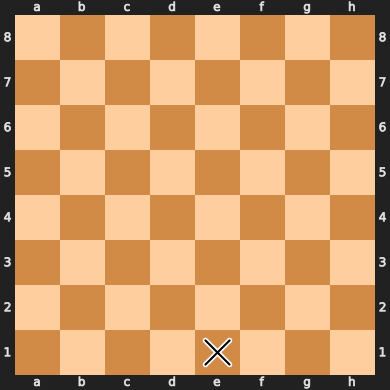

In [12]:
chess.SquareSet(squares=[4 for i in range(64)])

In [3]:
chess.Board(to_fen_c([1, 4] + [None]*60 + [9, 6]))

NameError: name 'to_fen_c' is not defined

In [3]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [8]:
!pip install --upgrade torchvision

/home/calum/anaconda3/lib/python3.8/site-packages/secretstorage/__init__.py:10: UserWarning: jeepney.integrate.blocking is deprecated: please use jeepney.io.blocking instead.
  from jeepney.integrate.blocking import DBusConnection, connect_and_authenticate
You should consider upgrading via the '/home/calum/anaconda3/bin/python -m pip install --upgrade pip' command.


In [8]:
import sys
sys.path.append('..')
from chessvision.util import *
os.environ[STORAGE_ENV] = "/home/calum/Documents/uni/chess-vision/games"
import chessvision.label as label
from chessvision.game import *
from chessvision.trainer import *
from chessvision.interpret import *
from chessvision.camera import *
import chess
import torch

In [9]:
occupancy_model = torch.load("/home/calum/Documents/uni/chess-vision/runs/276fbf8d68f24d58b391d7f1249de15c/model", map_location=torch.device('cpu'))
occupancy_config = torch.load("/home/calum/Documents/uni/chess-vision/runs/276fbf8d68f24d58b391d7f1249de15c/config", map_location=torch.device('cpu'))
def occupancy_nn(imgs):
    """ Uses a torch model to detect occupied squares 
    
    Returns: Dict[square_id: square_img]
    """
    squares = torch.stack(
        [occupancy_config.infer_transform(square) for square in imgs]
    )
    return [i for i, occupied in enumerate(occupancy_model(squares).argmax(dim=1)) if occupied.item() == 0]

In [10]:
game = Game("Nakamura", 7)
# 94, 23, 1
images = list(game.images)
corners = find_corners(images); print(corners)

[[ 460.56818  947.59033]
 [1240.7273   948.48676]
 [ 469.09787  169.63043]
 [1237.9271   163.28375]]


In [11]:
labeller = labellers['piece']

In [20]:
model = torch.load("/home/calum/Documents/uni/chess-vision/runs/a4506b0bb2674c8b8b91d6b5dede9ea6/model", map_location=torch.device('cpu'))
config = torch.load("/home/calum/Documents/uni/chess-vision/runs/a4506b0bb2674c8b8b91d6b5dede9ea6/config", map_location=torch.device('cpu'))
def proposed(imgs):
    occupied = occupancy_nn(imgs)
    occupied_dict = {i: occupied.index(i) for i in occupied}
    if len(occupied) == 0:
        return []
    squares = torch.stack(
        [config.infer_transform(imgs[i]) for i in occupied]
    )
    pieces = model(squares).argmax(dim=1)
    print(pieces)
    return {i: labeller.classes[pieces[occupied_dict[i]]] for i in range(64) if i in occupied_dict}

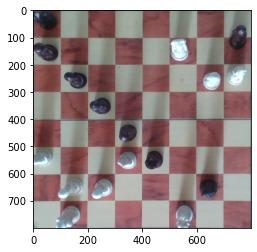

In [28]:
img = cv2.cvtColor(get_board(images[74]['color'], corners), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [29]:
pieces = proposed(list(get_squares(img)))

tensor([ 6, 10,  9,  0,  0,  7,  0,  0,  1,  1, 10,  0,  1,  1,  8,  1,  1, 11])


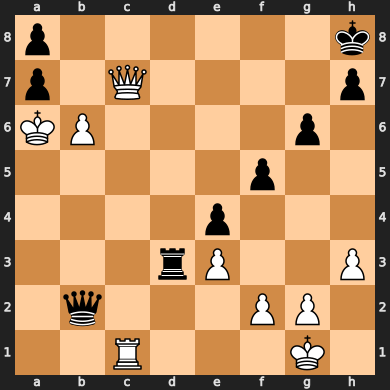

In [30]:
from cairosvg import svg2png
result = chess.Board()
result.set_piece_map(pieces)
svg2png(result._repr_svg_(), write_to='proposed_small_3.png')
result

In [3]:
# dir = save_games([Game("Bird", 2)], config.label_fn, config.classes)
ds = ChessFolder(root="/tmp/chess-vision-d4oha94u", transform=config.transform)
loader = DataLoader(ds, shuffle=True, batch_size=2, num_workers=4, pin_memory=True)

In [4]:
interp = Interpreter(model, loader, config.loss_fn)

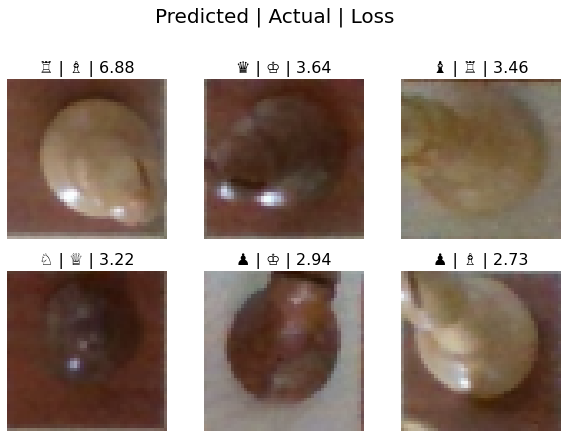

In [5]:
c = interp.plot_top_losses()

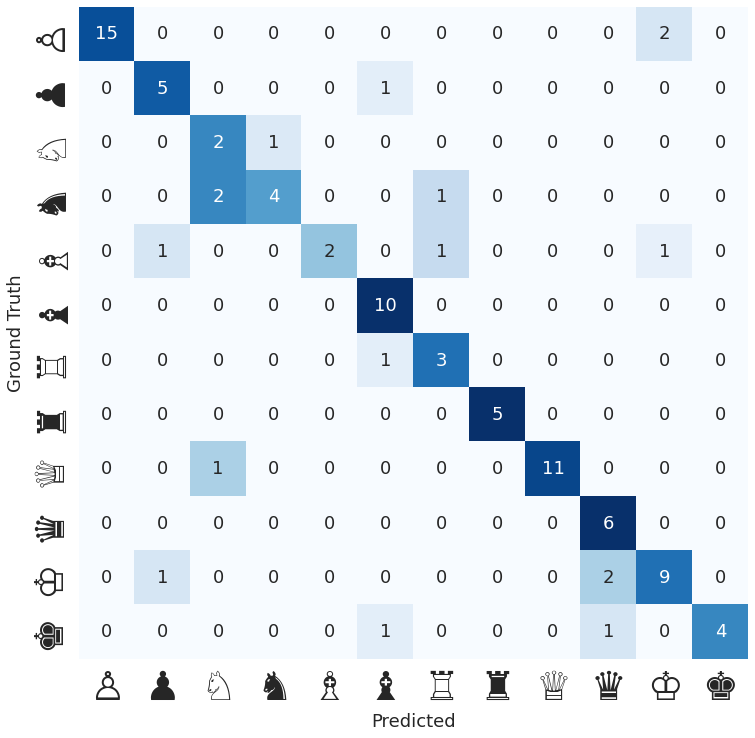

In [6]:
g = interp.plot_confusion_matrix()

In [19]:
model

ConvRes(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [35]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

11182668

In [39]:
p = next(iter(model.get_submodule("conv1").parameters()))
p.shape, p.numel(), model.get_submodule("conv1")

(torch.Size([64, 3, 7, 7]),
 9408,
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))

In [23]:
plt.imshow(model.get_parameter("layer4.1.conv2"))

AttributeError: `conv2` is not an nn.Parameter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


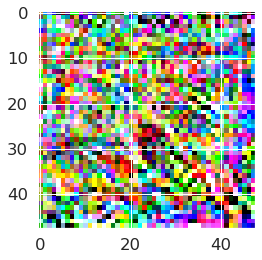

In [21]:
plt.imshow(interp.filter_visual("layer4.1.conv2", 0))